In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import auxiliar as aux
from preprocessing import init_dataset, standarize, normalize, scale

# **Gaussian Naive Bayes**

Los hiperparámetros que consideramos relevantes para el modelo GaussianNB son:
   - var_smoothing: Porción de la varianza más grande de todos los features que se agrega a las varianzas para la estabilidad del cálculo.

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto únicamente tratar los missings como categóricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas numéricas. En este caso no nos hace falta aplicar OHE. Tampoco nos sirve los preprocesamientos de reduccion por frecuencia o discretizacion, puesto que esto eliminaría o generaría nuevas columnas categóricas.

In [3]:
X_continuos = X.select_dtypes(include=['int64','int32'])
X_continuos.head()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas
0,17,39,2174,40
1,17,50,0,13
2,13,38,0,40
3,11,53,0,40
4,17,28,0,40


Primero vamos a analizar como funciona nuestro modelo sin aplicar ningun tipo de preprocesamiento. Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [4]:
X_train, X_validation, y_train, y_validation = train_test_split(X_continuos, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo gaussiano con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [5]:
parameters = {
    'var_smoothing': np.arange(0, 1e-6, 1e-8)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8363573041413668
Mejores Parametros {'var_smoothing': 1e-08}

Mejor score ROC-AUC en Validación: 0.8346435793731042


Armamos el modelo de GaussianNB con los hiperparametros calculados:

In [6]:
model_gaussianNB = gscv.best_estimator_
model_gaussianNB

GaussianNB(var_smoothing=1e-08)

Predecimos con el validation set:

In [7]:
gaussianNB_predict = model_gaussianNB.predict(X_validation)

**Metricas**

In [8]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4945
           1       0.74      0.22      0.34      1568

    accuracy                           0.79      6513
   macro avg       0.77      0.60      0.61      6513
weighted avg       0.78      0.79      0.75      6513



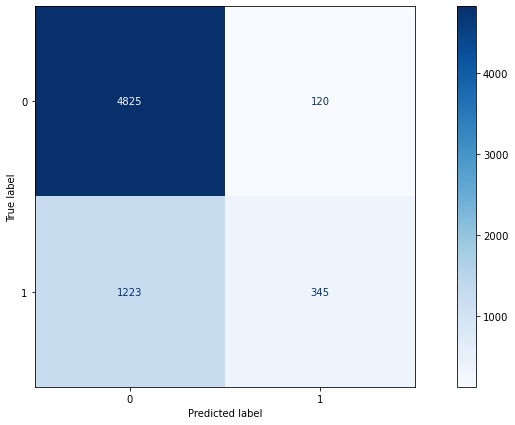

In [9]:
aux.plot_cm(model_gaussianNB, X_validation, y_validation)

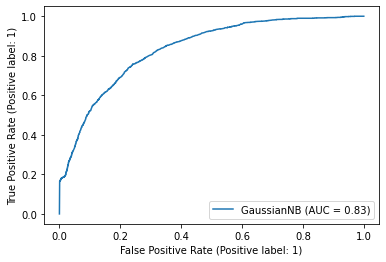

In [10]:
plot_roc_curve(model_gaussianNB, X_validation, y_validation, response_method="predict_proba")
plt.show()

Vemos que el modelo gaussiano predice muy mal la clase 1 de nuestra variable objetivo, pues el recall para esta clase resulta ser un valor demasiado bajo.

### Preprocesamiento 1: Normalizacion

Ahora veremos que al realizar una normalizacion a nuestras columnas continuas tenemos una perdida de performance en la metrica *auc_roc*:

In [11]:
X_p1 = normalize(X_continuos)
X_p1

array([[7.81686779e-03, 1.79328143e-02, 9.99639446e-01, 1.83926301e-02],
       [3.12571831e-01, 9.19328914e-01, 0.00000000e+00, 2.39025518e-01],
       [2.29344320e-01, 6.70391090e-01, 0.00000000e+00, 7.05674832e-01],
       ...,
       [1.81450312e-01, 8.09547547e-01, 0.00000000e+00, 5.58308653e-01],
       [4.00616808e-01, 6.77966906e-01, 0.00000000e+00, 6.16333551e-01],
       [8.65273642e-04, 3.46109457e-03, 9.99990092e-01, 2.66238044e-03]])

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p1, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo gaussiano con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [13]:
parameters = {
    'var_smoothing': np.arange(0, 1e-6, 1e-8)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.6155231003953746
Mejores Parametros {'var_smoothing': 8.4e-07}

Mejor score ROC-AUC en Validación: 0.6275138771383174


Armamos el modelo de GaussianNB con los hiperparametros calculados:

In [14]:
model_gaussianNB_p1 = gscv.best_estimator_
model_gaussianNB_p1

GaussianNB(var_smoothing=8.4e-07)

Predecimos con el validation set:

In [15]:
gaussianNB_predict = model_gaussianNB_p1.predict(X_validation)

**Metricas**

In [16]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      4945
           1       0.58      0.32      0.41      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.62      0.64      6513
weighted avg       0.76      0.78      0.76      6513



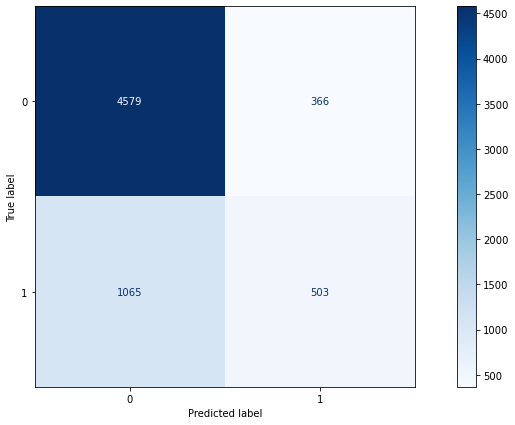

In [17]:
aux.plot_cm(model_gaussianNB_p1, X_validation, y_validation)

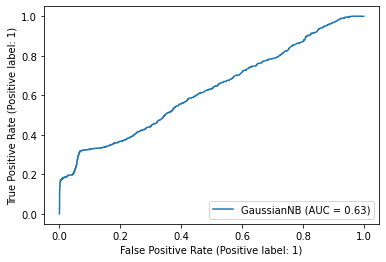

In [18]:
plot_roc_curve(model_gaussianNB_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

### Preprocesamiento 2: Escalado

Ahora veremos que ocurre con la metrica *auc_roc* si realizamos un escalado a nuestras columnas continuas. El rango de escalado es entre (0,1):

In [19]:
X_p2 = scale(X_continuos)
X_p2

array([[0.84210526, 0.30136986, 0.06257486, 0.39795918],
       [0.84210526, 0.45205479, 0.04174213, 0.12244898],
       [0.63157895, 0.28767123, 0.04174213, 0.39795918],
       ...,
       [0.63157895, 0.56164384, 0.04174213, 0.39795918],
       [0.63157895, 0.06849315, 0.04174213, 0.19387755],
       [0.63157895, 0.47945205, 0.18571223, 0.39795918]])

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p2,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo gaussiano con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [21]:
parameters = {
    'var_smoothing': np.arange(0, 1e-6, 1e-8)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.836209464438614
Mejores Parametros {'var_smoothing': 9.9e-07}

Mejor score ROC-AUC en Validación: 0.8343866072718269


Armamos el modelo de GaussianNB con los hiperparámetros calculados:

In [22]:
model_gaussianNB_p2 = gscv.best_estimator_
model_gaussianNB_p2

GaussianNB(var_smoothing=9.9e-07)

Predecimos con el validation set:

In [23]:
gaussianNB_predict = model_gaussianNB_p2.predict(X_validation)

**Metricas**

In [24]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4945
           1       0.75      0.22      0.34      1568

    accuracy                           0.79      6513
   macro avg       0.77      0.60      0.61      6513
weighted avg       0.79      0.79      0.75      6513



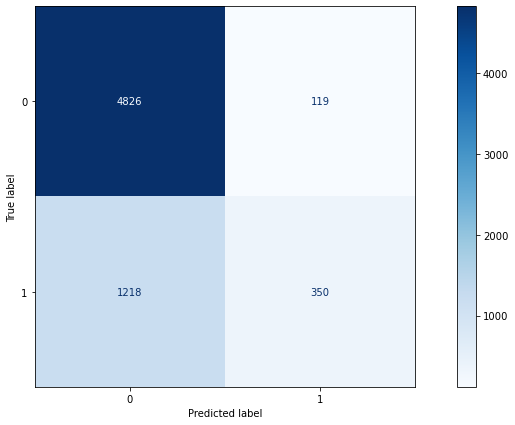

In [25]:
aux.plot_cm(model_gaussianNB_p2, X_validation, y_validation)

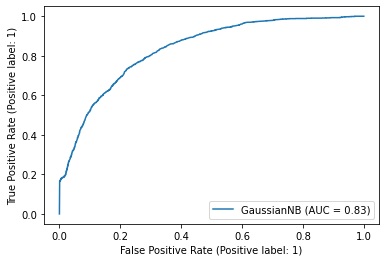

In [26]:
plot_roc_curve(model_gaussianNB_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

### Preprocesamiento 3: Estandarización

Ahora veremos que ocurre con la metrica *auc_roc* si realizamos una estandarización a nuestras columnas continuas:

In [27]:
X_p3 = standarize(X_continuos)
X_p3

array([[ 1.10571999,  0.03067056,  0.15976181, -0.03542945],
       [ 1.10571999,  0.83710898, -0.13367013, -2.22215312],
       [-0.39552984, -0.04264203, -0.13367013, -0.03542945],
       ...,
       [-0.39552984,  1.42360965, -0.13367013, -0.03542945],
       [-0.39552984, -1.21564337, -0.13367013, -1.65522476],
       [-0.39552984,  0.98373415,  1.89416861, -0.03542945]])

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [28]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p3,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo gaussiano con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [29]:
parameters = {
    'var_smoothing': np.arange(0, 1e-6, 1e-8)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8362078525201794
Mejores Parametros {'var_smoothing': 8.5e-07}

Mejor score ROC-AUC en Validación: 0.8343857689688615


Armamos el modelo GaussianNB con los hiperparámetros calculados:

In [30]:
model_gaussianNB_p3 = gscv.best_estimator_
model_gaussianNB_p3

GaussianNB(var_smoothing=8.5e-07)

Predecimos con el validation set:

In [31]:
gaussianNB_predict = model_gaussianNB_p3.predict(X_validation)

**Metricas**

In [32]:
print(classification_report(y_validation, gaussianNB_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4945
           1       0.75      0.22      0.34      1568

    accuracy                           0.79      6513
   macro avg       0.77      0.60      0.61      6513
weighted avg       0.79      0.79      0.75      6513



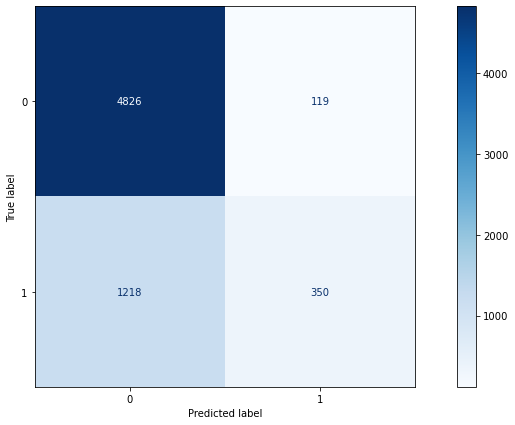

In [33]:
aux.plot_cm(model_gaussianNB_p3, X_validation, y_validation)

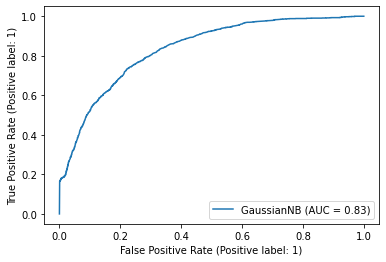

In [34]:
plot_roc_curve(model_gaussianNB_p3, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que utilizando GaussianNB quedandonos solo con las columnas numericas obtenemos una mal performance de la metrica *auc_roc* en comparación con los demas modelos. Esto era de esperar puesto que inicialmente nos quedamos únicamente con las columnas continuas eliminando así información que podría ser relevante para la predicción.
Por último vimos que aplicando tanto un escalado como una estandarización de las columnas numéricas resulta ser irrelevante para la metrica *auc_roc*, en cambio si aplicamos una normalización obtenemos una perdida de performance. Finalmente nos quedaremos con el preproceso de escalado.

# Predicción

Por último, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [35]:
ids, X_holdout = aux.get_holdout_set()
X_holdout = init_dataset(X_holdout)

In [36]:
X_holdout_continuos = X_holdout.select_dtypes(include=['int64','int32'])
X_holdout_continuos = scale(X_holdout_continuos)

In [37]:
gaussianNB_predict = model_gaussianNB_p2.predict(X_holdout_continuos)

In [38]:
aux.create_prediction(ids, gaussianNB_predict, file_name='gaussianNB')